In [1]:
# librerias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from PIL import Image

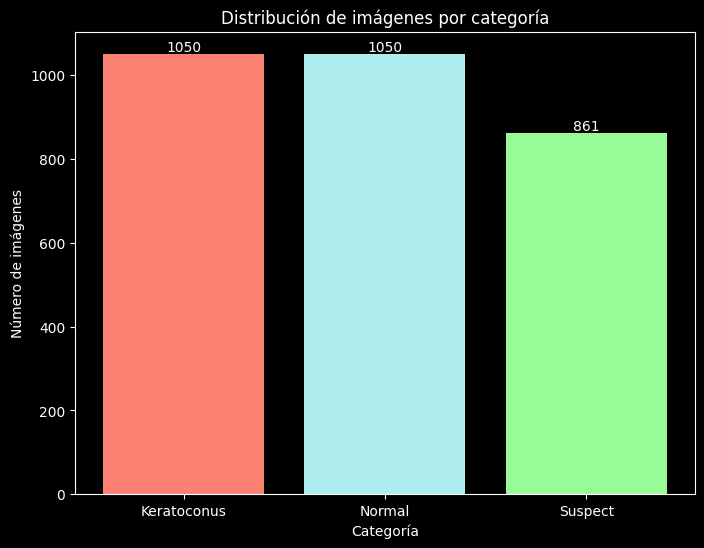

In [2]:
base_dir = r"Datos\Train"

#creamos una lista que nos permitirá ver la cantidad de imágenes por cada categoría
num_images_per_category = []

#Obtenemos la cantidad de impagenes que hay en cada una de las categorías, las cuales están como folders y vamos iterando para ver la cantidad por folder
folders = ["Keratoconus", "Normal", "Suspect"]
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    num_images = len(os.listdir(folder_path))
    num_images_per_category.append(num_images)

#Etiquetas para las categorías, las cuales son las 4 que ya se mencionaron
labels =  ["Keratoconus", "Normal", "Suspect"]

color = ['salmon', 'paleturquoise', 'palegreen']

#gráfica de distribución para ver la cantidad
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, num_images_per_category, color=color)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
    
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.title('Distribución de imágenes por categoría')
plt.show()

In [3]:
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    num_images = len(os.listdir(folder_path))
    print(f"Número de imágenes en '{folder}':", num_images)

Número de imágenes en 'Keratoconus': 1050
Número de imágenes en 'Normal': 1050
Número de imágenes en 'Suspect': 861


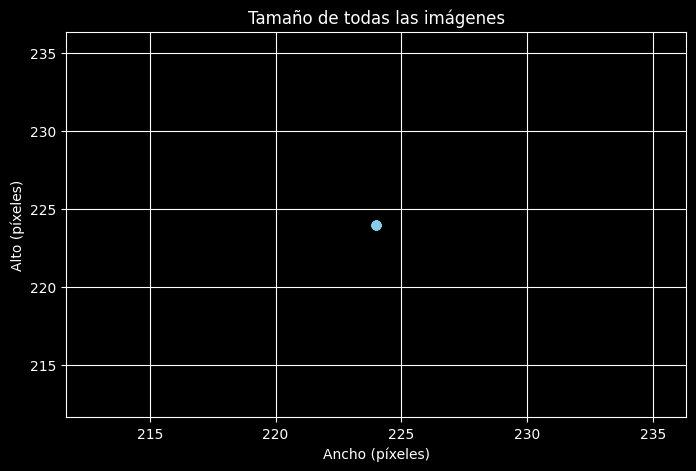

In [4]:
#Creamos una lista donde se va a estar almacenando el tamaño de las imágenes, es decir, largo y ancho
image_sizes = []


#vamos a hacer primero una iteración en cada folder, de nuevo
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    #y ahora vamos a iterar en cada imagen de cada folder, obteniendo la dirección del folder y el nombre de la imágen, realmente el nombre no es muy útil
    #pero la función necesitaba dos parámetros y ps colocamos este para no tener problemas xd
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        #una vez que se tenga una imgaen, calculamos el largo y ancho y lo agregamos a la lista creada arriba
        with Image.open(image_path) as img:
            width, height = img.size
            image_sizes.append((width, height))

#Separar los tamaños de ancho y largo, la primera entrada es el ancho de la imagen y la segunda entrada el alto
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

#para poder ver si hay diferencias entre los tamaños, hacemos una gráfica que nos muestre todos los tamaños de todas las imágenes, pequeño spoiler de nuevo, todas son
#el mismo tamaño, es una muy buena base para empezar
plt.figure(figsize=(8, 5))
plt.scatter(widths, heights, color='skyblue', alpha=0.5)
plt.title('Tamaño de todas las imágenes')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')
plt.grid(True)
plt.show()

In [118]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [122]:
train = r'Datos\Train'  # Carpeta de entrenamiento
test = r'Datos\Test'    # Carpeta de prueba

# Parámetros
img_size = (224, 224)
batch_size = 32

In [ ]:
# Generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Aumentación de datos (opcional)
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización

# Cargar imágenes desde carpetas
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Importante para evaluación
)

Found 2961 images belonging to 3 classes.
Found 1050 images belonging to 3 classes.


In [125]:
# compilación del modelo
model.compile(
    optimizer=optimizers.Adamax(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# resumen del modelo
model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,106,918 (76.70 MB)

 Trainable params: 20,064,895 (76.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [126]:
# detiene el modelo si considera que ya no cambia la pérdida
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# cambia el ritmo de aprendizaje si considera que se ha estancado
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

#Crea checkpoints del mejor modelo
checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

In [128]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/50
 6/93 ━━━━━━━━━━━━━━━━━━━━ 4:08 3s/step - accuracy: 0.3825 - loss: 1.6696

KeyboardInterrupt: 

In [79]:
#Evaluación del modelo
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión: {test_accuracy * 100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step - accuracy: 0.2456 - loss: 1.0932
Precisión: 33.33%


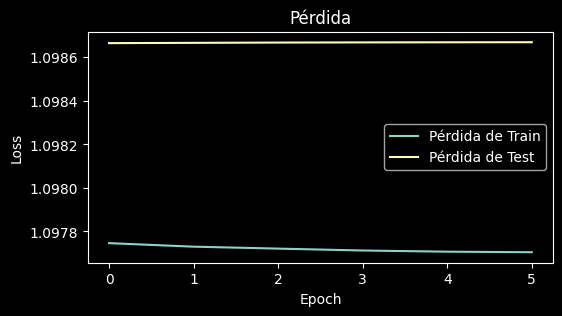

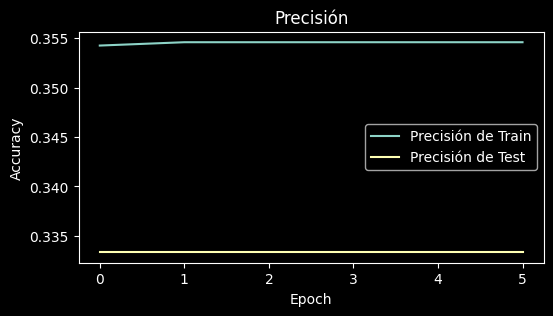

In [80]:
#Ploteamos los datos de Precisión y la Pérdida del modelo
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Pérdida de Train')
plt.plot(history.history['val_loss'], label='Pérdida de Test')
plt.title('Pérdida')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='Precisión de Train')
plt.plot(history.history['val_accuracy'], label='Precisión de Test')
plt.title('Precisión')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [81]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score

# Obtenemos las etiquetas reales
y_test = test_generator.classes

# Generamos las predicciones (probabilidades)
y_pred_prob = model.predict(test_generator)

# Para 3 clases, tomamos la clase con mayor probabilidad
y_pred = np.argmax(y_pred_prob, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step


Precisión: 0.3333333333333333
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       350
           1       0.33      1.00      0.50       350
           2       0.00      0.00      0.00       350

    accuracy                           0.33      1050
   macro avg       0.11      0.33      0.17      1050
weighted avg       0.11      0.33      0.17      1050



c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zahid\Escritorio\ProyectoTSBM\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

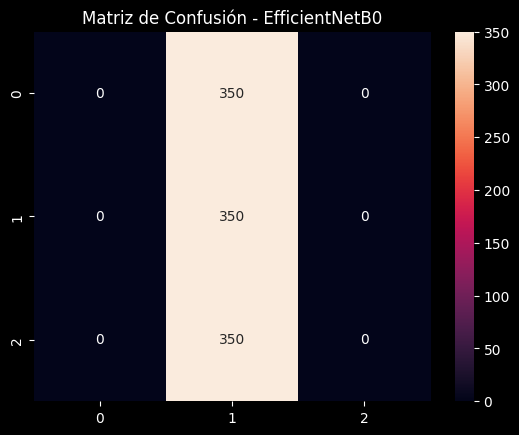

In [82]:
#Evaluamos el modelo
print("Precisión:", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

# Creamos una matriz de confusión
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot = True, fmt = 'g')
plt.title("Matriz de Confusión - EfficientNetB0")
plt.show()

## ------- Algo estoy haciendo mal ------- ##

In [83]:
# Descongelar capas superiores de EfficientNet
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers)//2]:  # Descongelar solo la mitad superior
    layer.trainable = False

# Recompilar con learning rate más bajo
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # LR bajo para fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar solo unas pocas épocas más
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3590 - loss: 2.4635 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 1.0000e-05
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4440 - loss: 1.1136 - val_accuracy: 0.2857 - val_loss: 1.1023 - learning_rate: 1.0000e-05
Epoch 3/20
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1:23 977ms/step - accuracy: 0.4834 - loss: 1.0223

KeyboardInterrupt: 

In [ ]:
# Evaluar en el conjunto de test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nPrecisión en test: {test_accuracy * 100:.2f}%")

# Generar reporte de clasificación
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

## SVC

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuración inicial
base_dir = r"Datos\Train"
categories = ["Keratoconus", "Normal", "Suspect"]
target_size = (125, 125)

# Carga de datos
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue
    
    print(f"Processing folder: {folder_path}")
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img_resized).flatten() / 255.0  # Normalización
                data.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

Processing folder: Datos\Train\Keratoconus
Processing folder: Datos\Train\Normal
Processing folder: Datos\Train\Suspect


In [25]:
# Convertir a arrays numpy
data = np.array(data)
labels = np.array(labels)

# Verificación
if data.shape[0] == 0:
    raise ValueError("No hay imágenes en el dataset.")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Data shape: (2961, 46875)
Labels shape: (2961,)


In [26]:
# Split de datos
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [27]:
# Entrenar SVM
svm_model = SVC(kernel='linear', verbose = 1)
svm_model.fit(X_train, y_train)

# Evaluación
y_pred = svm_model.predict(X_test)

# Métricas para 3 clases
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred, target_names=categories))

[LibSVM]
--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Keratoconus       0.91      0.95      0.93       223
      Normal       0.69      0.72      0.71       198
     Suspect       0.63      0.56      0.59       172

    accuracy                           0.76       593
   macro avg       0.74      0.74      0.74       593
weighted avg       0.76      0.76      0.76       593




Exactitud (Accuracy): 0.7605

--- Matriz de Confusión ---


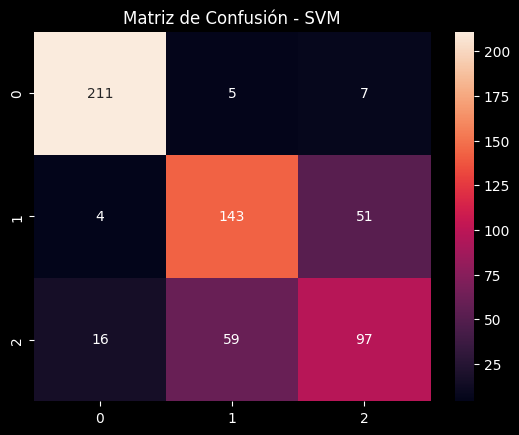

In [28]:
print(f"\nExactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'g')
plt.title("Matriz de Confusión - SVM")
plt.show()

### RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuración inicial
base_dir = r"Datos\Train"
categories = ["Keratoconus", "Normal", "Suspect"]
target_size = (125, 125)

# Carga de datos (igual que antes)
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue
    
    print(f"Processing folder: {folder_path}")
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img_resized).flatten() / 255.0  # Normalización
                data.append(img_array)
                labels.append(label)
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

Processing folder: Datos\Train\Keratoconus
Processing folder: Datos\Train\Normal
Processing folder: Datos\Train\Suspect


In [30]:
# Convertir a arrays numpy
data = np.array(data)
labels = np.array(labels)

# Verificación
if data.shape[0] == 0:
    raise ValueError("No hay imágenes en el dataset.")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Data shape: (2961, 46875)
Labels shape: (2961,)


In [31]:
# Split de datos
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:

rf_model = RandomForestClassifier(
    n_estimators=400, 
    max_depth=10,
    random_state=None,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluación (igual que con SVM pero ahora para Random Forest)
y_pred = rf_model.predict(X_test)


In [39]:
# Métricas
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred, target_names=categories))


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Keratoconus       0.90      0.94      0.92       223
      Normal       0.89      0.76      0.82       198
     Suspect       0.71      0.79      0.75       172

    accuracy                           0.84       593
   macro avg       0.83      0.83      0.83       593
weighted avg       0.84      0.84      0.84       593




Exactitud (Accuracy): 0.8364

--- Matriz de Confusión ---


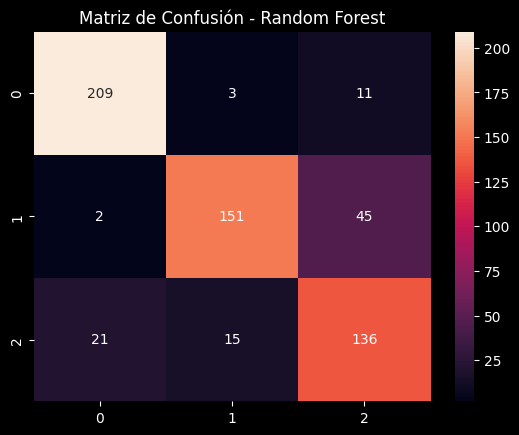

In [40]:
print(f"\nExactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")

# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'g')
plt.title("Matriz de Confusión - Random Forest")
plt.show()